In [1]:
import os 
import pandas as pd
import numpy as np

from src.utils.dict_loader import TopicDictionary
from src.utils.output_loader import load_all_topvecs, load_all_bstr_arrs
from src.utils.downstream_aggregate import normalize

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

import yaml
with open("../../src/configs.yml", "r") as configs:
    configs = yaml.safe_load(configs)

ROOTPATH = configs["ROOTPATH"]

START2016 = pd.to_datetime(configs["START2016"])
END2016 = pd.to_datetime(configs["END2016"])
START2020 = pd.to_datetime(configs["START2020"])
END2020 = pd.to_datetime(configs["END2020"])

INPUT_FPATH = configs["DATE_TOPVEC_PATH"]
print(f"INPUT_FPATH=={INPUT_FPATH}")

OUTPUT_FPATH = ROOTPATH + "output/figs/"
print(f"OUTPUT_FPATH=={OUTPUT_FPATH}")

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/yijingch/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yijingch/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


INPUT_FPATH==/Users/yijingch/Documents/GITHUB/intermedia-agenda-setting/output/date-topvec-min2-gtm1/
OUTPUT_FPATH==/Users/yijingch/Documents/GITHUB/intermedia-agenda-setting/output/figs/


In [2]:
from src.utils.dict_configuration import dictionary2016, dictionary2020

TOPICS2DROP = [
    "election_campaign", "general_controversies", "no_topic", 
    "forestry", "land_water_management", "agriculture", "housing", 
    "transportation", "culture"]

TOPICS2DROP_IDX2016 = [dictionary2016.topic2index[x] for x in TOPICS2DROP]
TOPICS2DROP_IDX2020 = [dictionary2020.topic2index[x] for x in TOPICS2DROP]

Successfully loaded dictionary!
	# of unique topics: 27
	# of unique words: 1426
Successfully loaded dictionary!
	# of unique topics: 27
	# of unique words: 1453


In [3]:
ABBR_MAP = {
    "healthcare":"HLTH", 
    "election_campaign":"ELEC", 
    "general_controversies":"GENC", 
    "trump_controversies":"TRUC", 
    "civil_rights":"CIVR", 
    "crime":"CRIM", 
    "clinton_controversies":"CLIC", 
    "biden_controversies":"BIDC",
    "intl_affairs":"INTL", 
    "government_ops":"GVOP", 
    "energy":"ENRG", 
    "economy":"ECON", 
    "sstc":"SSTC", 
    "foreign_trade":"FRTR", 
    "immigration":"IMMI", 
    "social_welfare":"SOWL", 
    "education":"EDUC", 
    "environment":"ENVR", 
    "labour":"LABR", 
    "defence":"DEFC", 
    "religion":"RELG", 
    "agriculture":"AGRI", 
    "housing":"HOUS", 
    "transportation":"TRSP", 
    "land_water_management":"LWMN", 
    "forestry":"FRST", 
    "culture":"CLTR", 
    "no_topic":"NA", 
}

COLORMAP = {
    "low-cred": "#FFB000",
    "traditional": "#A2678A",
    "left": "#4A55A2",
    "right": "#B31312", 
    "DEM": "#4A55A2",
    "REP": "#B31312", 
    "NA":"white"
}

RESULT_COLOR_MAP = {
    "led_by_trad_only_trump": COLORMAP["traditional"],
    "led_by_trad_only_clinton": COLORMAP["traditional"],
    "led_by_trad_only_biden": COLORMAP["traditional"],
    "led_by_lowc_only_trump": COLORMAP["low-cred"],
    "led_by_lowc_only_clinton": COLORMAP["low-cred"],
    "led_by_lowc_only_biden": COLORMAP["low-cred"],
    "led_by_left_only_trump": COLORMAP["left"],
    "led_by_left_only_clinton": COLORMAP["left"],
    "led_by_left_only_biden": COLORMAP["left"],
    "led_by_right_only_trump": COLORMAP["right"],
    "led_by_right_only_clinton": COLORMAP["right"],
    "led_by_right_only_biden": COLORMAP["right"],
    "mutual_trump": "seagreen",
    "mutual_clinton": "seagreen",
    "mutual_biden": "seagreen",
    "no_relation_trump": "lightgrey",
    "no_relation_clinton": "lightgrey",
    "no_relation_biden": "lightgrey",
    "NO_SIG_RESULT":"none"
    # "NO_SIG_RESULT":"white"
}

In [4]:
topvec_dfs2016 = load_all_topvecs(year=2016, topvec_fpath=INPUT_FPATH, normalize_by_unit=True)
topvec_dfs2020 = load_all_topvecs(year=2020, topvec_fpath=INPUT_FPATH, normalize_by_unit=True)

bstr_arrs2016 = load_all_bstr_arrs(year=2016, vec_fpath=INPUT_FPATH, vec_type="topvecs", normalize_by_unit=True)
bstr_arrs2020 = load_all_bstr_arrs(year=2020, vec_fpath=INPUT_FPATH, vec_type="topvecs", normalize_by_unit=True)

In [5]:
# LOAD EVENTS 
events = pd.read_csv(ROOTPATH + "index/events.tsv", sep="\t")
events["start_date"] = pd.to_datetime(events["start_date"])
events["end_date"] = pd.to_datetime(events["end_date"])
events["year"] = events["start_date"].map(lambda x: x.year)
events_2016 = events[events["year"]==2016].reset_index()
events_2020 = events[events["year"]==2020].reset_index()

## Load sliding IAS results

In [6]:
WINDOW_LEN = 90
year = 2020
if year == 2016:
    cand1 = "trump"
    cand2 = "clinton"
    dictionary = dictionary2016
    topvec_dfs = topvec_dfs2016
    bstr_arrs = bstr_arrs2016
    events_year = events_2016
elif year == 2020:
    cand1 = "biden"
    cand2 = "trump"
    dictionary = dictionary2020
    topvec_dfs = topvec_dfs2020
    bstr_arrs = bstr_arrs2020
    events_year = events_2020

import ast
tmp_plot_ias = pd.read_csv(ROOTPATH + f"output/ias-sliding-window/ideo_{year}_window{WINDOW_LEN}.csv")
tmp_plot_ias["date"] = pd.to_datetime(tmp_plot_ias["date"])
tmp_plot_ias[f"res_{cand1}"] = tmp_plot_ias[f"res_{cand1}"].map(lambda x: ast.literal_eval(x))
tmp_plot_ias[f"res_{cand2}"] = tmp_plot_ias[f"res_{cand2}"].map(lambda x: ast.literal_eval(x))

In [7]:
topic_sum = np.sum(np.array(topvec_dfs["headline"][0][0]["majority_topvec"].tolist()), axis=0)
topic_sum += np.sum(np.array(topvec_dfs["headline"][1][0]["majority_topvec"].tolist()), axis=0)
TOP_TOPICS = [dictionary.index2topic[str(t)] for t in np.argsort(-topic_sum) if dictionary.index2topic[str(t)] not in TOPICS2DROP]
TOP_TOPICS = TOP_TOPICS[:10]

TOP_TOPICS.reverse()
print(TOP_TOPICS)

['defence', 'economy', 'intl_affairs', 'sstc', 'civil_rights', 'trump_controversies', 'biden_controversies', 'crime', 'healthcare', 'government_ops']


## FOR CRED GROUP

In [8]:
tmp_plot_ias

,date,res_biden,res_trump,healthcare_biden,healthcare_trump,biden_controversies_biden,biden_controversies_trump,trump_controversies_biden,trump_controversies_trump,civil_rights_biden,...,labour_biden,labour_trump,education_biden,education_trump,social_welfare_biden,social_welfare_trump,religion_biden,religion_trump,defence_biden,defence_trump
0,2020-07-01,"{'healthcare': 'no_relation_biden', 'biden_con...","{'healthcare': 'NO_SIG_RESULT', 'biden_controv...",no_relation_biden,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,...,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT
1,2020-07-02,"{'healthcare': 'no_relation_biden', 'biden_con...","{'healthcare': 'NO_SIG_RESULT', 'biden_controv...",no_relation_biden,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,...,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT
2,2020-07-03,"{'healthcare': 'no_relation_biden', 'biden_con...","{'healthcare': 'NO_SIG_RESULT', 'biden_controv...",no_relation_biden,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,...,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT
3,2020-07-04,"{'healthcare': 'no_relation_biden', 'biden_con...","{'healthcare': 'NO_SIG_RESULT', 'biden_controv...",no_relation_biden,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,...,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT
4,2020-07-05,"{'healthcare': 'no_relation_biden', 'biden_con...","{'healthcare': 'NO_SIG_RESULT', 'biden_controv...",no_relation_biden,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,...,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,2020-08-27,"{'healthcare': 'NO_SIG_RESULT', 'biden_controv...","{'healthcare': 'led_by_left_only_trump', 'bide...",NO_SIG_RESULT,led_by_left_only_trump,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,...,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,no_relation_trump,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,no_relation_trump,NO_SIG_RESULT,NO_SIG_RESULT
58,2020-08-28,"{'healthcare': 'NO_SIG_RESULT', 'biden_controv...","{'healthcare': 'led_by_left_only_trump', 'bide...",NO_SIG_RESULT,led_by_left_only_trump,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,led_by_left_only_trump,NO_SIG_RESULT,...,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,no_relation_trump,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,no_relation_trump,NO_SIG_RESULT,NO_SIG_RESULT
59,2020-08-29,"{'healthcare': 'NO_SIG_RESULT', 'biden_controv...","{'healthcare': 'led_by_left_only_trump', 'bide...",NO_SIG_RESULT,led_by_left_only_trump,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,led_by_left_only_trump,NO_SIG_RESULT,...,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,no_relation_trump,NO_SIG_RESULT,NO_SIG_RESULT
60,2020-08-30,"{'healthcare': 'NO_SIG_RESULT', 'biden_controv...","{'healthcare': 'led_by_left_only_trump', 'bide...",NO_SIG_RESULT,led_by_left_only_trump,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,led_by_left_only_trump,NO_SIG_RESULT,...,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,NO_SIG_RESULT,no_relation_trump,NO_SIG_RESULT,NO_SIG_RESULT


In [9]:
# 2016 TRAD
# TRUMP 49
# CLINTON 54

# 2020 TRAD
# BIDEN 47
# TRUMP 58 

In [10]:
# len(tmp_plot_ias[tmp_plot_ias["trump_controversies_trump"]=="led_by_trad_only_trump"])

In [11]:
# len(tmp_plot_ias[tmp_plot_ias["biden_controversies_biden"]=="led_by_trad_only_biden"])
# len(tmp_plot_ias[tmp_plot_ias["clinton_controversies_clinton"]=="led_by_trad_only_clinton"])

In [12]:
# # 2016
# import matplotlib.cm as cm
# fig, ax = plt.subplots(figsize=(8,8), nrows=2, sharex=True)
# # ALL_TOPICS = list(tmp_plot_ias[f"res_{cand1}"].tolist()[0].keys())
# YTICKS = []

# for i,row in events_year.iterrows():
#     ax[0].axvspan(row["start_date"], row["end_date"]+pd.DateOffset(1), 
#                 alpha=0.2, label=row["event"], color=cm.jet(i/(len(events_year))))
#     ax[1].axvspan(row["start_date"], row["end_date"]+pd.DateOffset(1), 
#                 alpha=0.2, label=row["event"], color=cm.jet(i/(len(events_year))))

# for i,t in enumerate(TOP_TOPICS):
#     df_subset1 = tmp_plot_ias[tmp_plot_ias[f"{t}_{cand1}"]!="NO_SIG_RESULT"]
#     df_subset2 = tmp_plot_ias[tmp_plot_ias[f"{t}_{cand2}"]!="NO_SIG_RESULT"]
#     ax[0].scatter(
#         df_subset1["date"], [i]*len(df_subset1), 
#         color=df_subset1[f"{t}_{cand1}"].map(lambda x: RESULT_COLOR_MAP[x]), marker="+")
    
#     ax[1].scatter(
#         df_subset2["date"], [i]*len(df_subset2), 
#         color=df_subset2[f"{t}_{cand2}"].map(lambda x: RESULT_COLOR_MAP[x]), marker="+")

#     for m in range(1,WINDOW_LEN+1):
#         ax[0].scatter(
#             df_subset1["date"] + pd.Timedelta(days=m), [i]*len(df_subset1), 
#             color=df_subset1[f"{t}_{cand1}"].map(lambda x: RESULT_COLOR_MAP[x]), marker=".", s=3)
#         ax[1].scatter(
#             df_subset2["date"] + pd.Timedelta(days=m), [i]*len(df_subset2), 
#             color=df_subset2[f"{t}_{cand2}"].map(lambda x: RESULT_COLOR_MAP[x]), marker=".", s=3)

# ax[0].set_yticks(range(len(TOP_TOPICS)), [ABBR_MAP[x] for x in TOP_TOPICS], fontsize=11)
# ax[1].set_yticks(range(len(TOP_TOPICS)), [ABBR_MAP[x] for x in TOP_TOPICS], fontsize=11)
# ax[-1].scatter(tmp_plot_ias["date"], [-10]*len(tmp_plot_ias), marker="s", color=RESULT_COLOR_MAP["led_by_trad_only_biden"], label="led by high-cred")
# ax[-1].scatter(tmp_plot_ias["date"], [-10]*len(tmp_plot_ias), marker="s", color=RESULT_COLOR_MAP["led_by_lowc_only_biden"], label="led by low-cred")
# ax[-1].scatter(tmp_plot_ias["date"], [-10]*len(tmp_plot_ias), marker="s", color=RESULT_COLOR_MAP["mutual_biden"], label="mutual interaction")
# ax[-1].scatter(tmp_plot_ias["date"], [-10]*len(tmp_plot_ias), marker="s", color=RESULT_COLOR_MAP["no_relation_biden"], label="no relationship")
# ax[-1].scatter(tmp_plot_ias["date"], [-10]*len(tmp_plot_ias), marker="+", color="grey", label="[start] of the 90-day window")
# ax[-1].scatter(tmp_plot_ias["date"], [-10]*len(tmp_plot_ias), marker=".", s=3, color="grey", label="[interval] of the 90-day window")

# ax[-1].legend(bbox_to_anchor=(1.5, 2.25))
# ax[0].set_title(cand1.capitalize(), fontsize=16)
# ax[1].set_title(cand2.capitalize(), fontsize=16)
# for i in range(2):
#     ax[i].set_ylim(-1,len(TOP_TOPICS))
# # fig.subplots_adjust(top=2)
# # plt.tight_layout()
# plt.savefig(OUTPUT_FPATH + f"CRED_granger_moving_window_{year}_window{WINDOW_LEN}.pdf", dpi=300, bbox_inches="tight")

In [13]:
# # 2020
# import matplotlib.cm as cm
# fig, ax = plt.subplots(figsize=(8,8), nrows=2, sharex=True)
# # ALL_TOPICS = list(tmp_plot_ias[f"res_{cand1}"].tolist()[0].keys())
# YTICKS = []

# for i,row in events_year.iterrows():
#     ax[1].axvspan(row["start_date"], row["end_date"]+pd.DateOffset(1), 
#                 alpha=0.2, label=row["event"], color=cm.jet(i/(len(events_year))))
#     ax[0].axvspan(row["start_date"], row["end_date"]+pd.DateOffset(1), 
#                 alpha=0.2, label=row["event"], color=cm.jet(i/(len(events_year))))

# for i,t in enumerate(TOP_TOPICS):
#     df_subset1 = tmp_plot_ias[tmp_plot_ias[f"{t}_{cand1}"]!="NO_SIG_RESULT"]
#     df_subset2 = tmp_plot_ias[tmp_plot_ias[f"{t}_{cand2}"]!="NO_SIG_RESULT"]
#     ax[1].scatter(
#         df_subset1["date"], [i]*len(df_subset1), 
#         color=df_subset1[f"{t}_{cand1}"].map(lambda x: RESULT_COLOR_MAP[x]), marker="+")
#     # print()
#     ax[0].scatter(
#         df_subset2["date"], [i]*len(df_subset2), 
#         color=df_subset2[f"{t}_{cand2}"].map(lambda x: RESULT_COLOR_MAP[x]), marker="+")

#     for m in range(1,WINDOW_LEN):
#         ax[1].scatter(
#             df_subset1["date"] + pd.Timedelta(days=m), [i]*len(df_subset1), 
#             color=df_subset1[f"{t}_{cand1}"].map(lambda x: RESULT_COLOR_MAP[x]), marker=".", s=3)
#         ax[0].scatter(
#             df_subset2["date"] + pd.Timedelta(days=m), [i]*len(df_subset2), 
#             color=df_subset2[f"{t}_{cand2}"].map(lambda x: RESULT_COLOR_MAP[x]), marker=".", s=3)

# ax[1].set_yticks(range(len(TOP_TOPICS)), [ABBR_MAP[x] for x in TOP_TOPICS], fontsize=11)
# ax[0].set_yticks(range(len(TOP_TOPICS)), [ABBR_MAP[x] for x in TOP_TOPICS], fontsize=11)
# ax[-1].scatter(tmp_plot_ias["date"], [-10]*len(tmp_plot_ias), marker="s", color=RESULT_COLOR_MAP["led_by_trad_only_biden"], label="led by high-cred")
# ax[-1].scatter(tmp_plot_ias["date"], [-10]*len(tmp_plot_ias), marker="s", color=RESULT_COLOR_MAP["led_by_lowc_only_biden"], label="led by low-cred")
# ax[-1].scatter(tmp_plot_ias["date"], [-10]*len(tmp_plot_ias), marker="s", color=RESULT_COLOR_MAP["mutual_biden"], label="mutual interaction")
# ax[-1].scatter(tmp_plot_ias["date"], [-10]*len(tmp_plot_ias), marker="s", color=RESULT_COLOR_MAP["no_relation_biden"], label="no relationship")
# ax[-1].scatter(tmp_plot_ias["date"], [-10]*len(tmp_plot_ias), marker="+", color="grey", label="[start] of the 90-day window")
# ax[-1].scatter(tmp_plot_ias["date"], [-10]*len(tmp_plot_ias), marker=".", s=3, color="grey", label="[interval] of the 90-day window")

# ax[-1].legend(bbox_to_anchor=(1., 2.25))
# ax[1].set_title(cand1.capitalize(), fontsize=16)
# ax[0].set_title(cand2.capitalize(), fontsize=16)
# for i in range(2):
#     ax[i].set_ylim(-1,len(TOP_TOPICS))
# # fig.subplots_adjust(top=2)
# # plt.tight_layout()
# plt.savefig(OUTPUT_FPATH + f"CRED_granger_moving_window_{year}_window{WINDOW_LEN}.pdf", dpi=300, bbox_inches="tight")

## FOR IDEO GROUP

In [14]:
# # 2016
# import matplotlib.cm as cm
# fig, ax = plt.subplots(figsize=(8,8), nrows=2, sharex=True)
# # ALL_TOPICS = list(tmp_plot_ias[f"res_{cand1}"].tolist()[0].keys())
# YTICKS = []

# for i,row in events_year.iterrows():
#     ax[0].axvspan(row["start_date"], row["end_date"]+pd.DateOffset(1), 
#                 alpha=0.2, label=row["event"], color=cm.jet(i/(len(events_year))))
#     ax[1].axvspan(row["start_date"], row["end_date"]+pd.DateOffset(1), 
#                 alpha=0.2, label=row["event"], color=cm.jet(i/(len(events_year))))

# for i,t in enumerate(TOP_TOPICS):
#     df_subset1 = tmp_plot_ias[tmp_plot_ias[f"{t}_{cand1}"]!="NO_SIG_RESULT"]
#     df_subset2 = tmp_plot_ias[tmp_plot_ias[f"{t}_{cand2}"]!="NO_SIG_RESULT"]
#     ax[0].scatter(
#         df_subset1["date"], [i]*len(df_subset1), 
#         color=df_subset1[f"{t}_{cand1}"].map(lambda x: RESULT_COLOR_MAP[x]), marker="+")
    
#     ax[1].scatter(
#         df_subset2["date"], [i]*len(df_subset2), 
#         color=df_subset2[f"{t}_{cand2}"].map(lambda x: RESULT_COLOR_MAP[x]), marker="+")

#     for m in range(1,WINDOW_LEN+1):
#         ax[0].scatter(
#             df_subset1["date"] + pd.Timedelta(days=m), [i]*len(df_subset1), 
#             color=df_subset1[f"{t}_{cand1}"].map(lambda x: RESULT_COLOR_MAP[x]), marker=".", s=3)
#         ax[1].scatter(
#             df_subset2["date"] + pd.Timedelta(days=m), [i]*len(df_subset2), 
#             color=df_subset2[f"{t}_{cand2}"].map(lambda x: RESULT_COLOR_MAP[x]), marker=".", s=3)

# ax[0].set_yticks(range(len(TOP_TOPICS)), [ABBR_MAP[x] for x in TOP_TOPICS], fontsize=11)
# ax[1].set_yticks(range(len(TOP_TOPICS)), [ABBR_MAP[x] for x in TOP_TOPICS], fontsize=11)
# ax[-1].scatter(tmp_plot_ias["date"], [-10]*len(tmp_plot_ias), marker="s", color=RESULT_COLOR_MAP["led_by_left_only_clinton"], label="led by left")
# ax[-1].scatter(tmp_plot_ias["date"], [-10]*len(tmp_plot_ias), marker="s", color=RESULT_COLOR_MAP["led_by_right_only_clinton"], label="led by right")
# ax[-1].scatter(tmp_plot_ias["date"], [-10]*len(tmp_plot_ias), marker="s", color=RESULT_COLOR_MAP["mutual_clinton"], label="mutual interaction")
# ax[-1].scatter(tmp_plot_ias["date"], [-10]*len(tmp_plot_ias), marker="s", color=RESULT_COLOR_MAP["no_relation_clinton"], label="no relationship")
# ax[-1].scatter(tmp_plot_ias["date"], [-10]*len(tmp_plot_ias), marker="+", color="grey", label="[start] of the 90-day window")
# ax[-1].scatter(tmp_plot_ias["date"], [-10]*len(tmp_plot_ias), marker=".", s=3, color="grey", label="[interval] of the 90-day window")

# ax[-1].legend(bbox_to_anchor=(1.5, 2.25))
# ax[0].set_title(cand1.capitalize(), fontsize=16)
# ax[1].set_title(cand2.capitalize(), fontsize=16)
# for i in range(2):
#     ax[i].set_ylim(-1,len(TOP_TOPICS))
# # fig.subplots_adjust(top=2)
# # plt.tight_layout()
# plt.savefig(OUTPUT_FPATH + f"IDEO_granger_moving_window_{year}_window{WINDOW_LEN}.pdf", dpi=300, bbox_inches="tight")

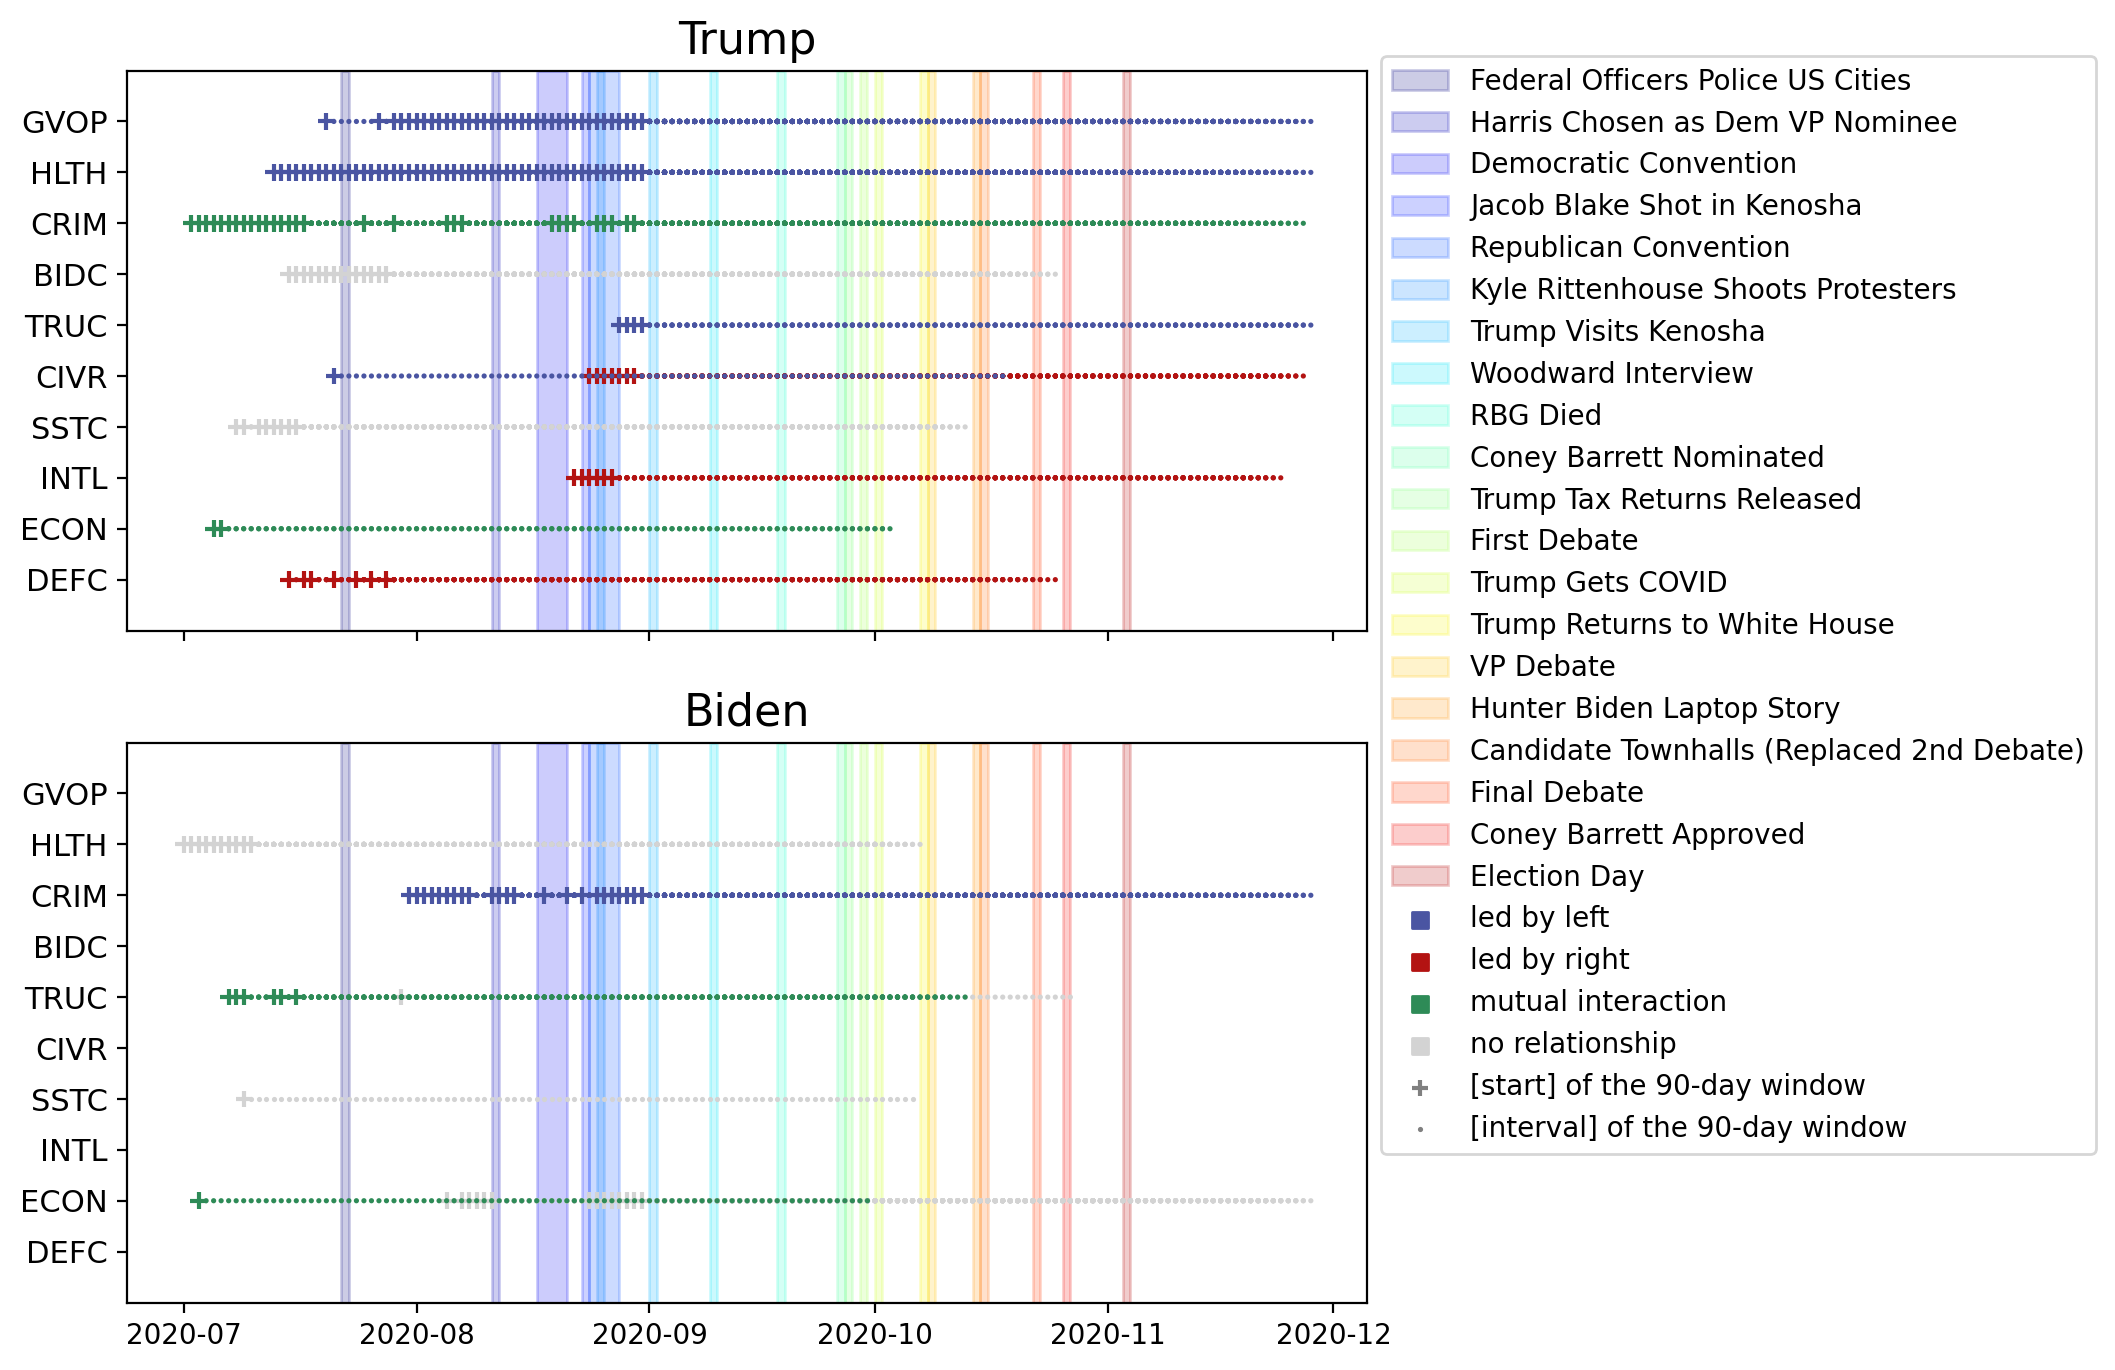

In [15]:
# 2020
import matplotlib.cm as cm
fig, ax = plt.subplots(figsize=(8,8), nrows=2, sharex=True)
# ALL_TOPICS = list(tmp_plot_ias[f"res_{cand1}"].tolist()[0].keys())
YTICKS = []

for i,row in events_year.iterrows():
    ax[1].axvspan(row["start_date"], row["end_date"]+pd.DateOffset(1), 
                alpha=0.2, label=row["event"], color=cm.jet(i/(len(events_year))))
    ax[0].axvspan(row["start_date"], row["end_date"]+pd.DateOffset(1), 
                alpha=0.2, label=row["event"], color=cm.jet(i/(len(events_year))))

for i,t in enumerate(TOP_TOPICS):
    df_subset1 = tmp_plot_ias[tmp_plot_ias[f"{t}_{cand1}"]!="NO_SIG_RESULT"]
    df_subset2 = tmp_plot_ias[tmp_plot_ias[f"{t}_{cand2}"]!="NO_SIG_RESULT"]
    ax[1].scatter(
        df_subset1["date"], [i]*len(df_subset1), 
        color=df_subset1[f"{t}_{cand1}"].map(lambda x: RESULT_COLOR_MAP[x]), marker="+")
    # print()
    ax[0].scatter(
        df_subset2["date"], [i]*len(df_subset2), 
        color=df_subset2[f"{t}_{cand2}"].map(lambda x: RESULT_COLOR_MAP[x]), marker="+")

    for m in range(1,WINDOW_LEN):
        ax[1].scatter(
            df_subset1["date"] + pd.Timedelta(days=m), [i]*len(df_subset1), 
            color=df_subset1[f"{t}_{cand1}"].map(lambda x: RESULT_COLOR_MAP[x]), marker=".", s=3)
        ax[0].scatter(
            df_subset2["date"] + pd.Timedelta(days=m), [i]*len(df_subset2), 
            color=df_subset2[f"{t}_{cand2}"].map(lambda x: RESULT_COLOR_MAP[x]), marker=".", s=3)

ax[1].set_yticks(range(len(TOP_TOPICS)), [ABBR_MAP[x] for x in TOP_TOPICS], fontsize=11)
ax[0].set_yticks(range(len(TOP_TOPICS)), [ABBR_MAP[x] for x in TOP_TOPICS], fontsize=11)
ax[-1].scatter(tmp_plot_ias["date"], [-10]*len(tmp_plot_ias), marker="s", color=RESULT_COLOR_MAP["led_by_left_only_biden"], label="led by left")
ax[-1].scatter(tmp_plot_ias["date"], [-10]*len(tmp_plot_ias), marker="s", color=RESULT_COLOR_MAP["led_by_right_only_biden"], label="led by right")
ax[-1].scatter(tmp_plot_ias["date"], [-10]*len(tmp_plot_ias), marker="s", color=RESULT_COLOR_MAP["mutual_biden"], label="mutual interaction")
ax[-1].scatter(tmp_plot_ias["date"], [-10]*len(tmp_plot_ias), marker="s", color=RESULT_COLOR_MAP["no_relation_biden"], label="no relationship")
ax[-1].scatter(tmp_plot_ias["date"], [-10]*len(tmp_plot_ias), marker="+", color="grey", label="[start] of the 90-day window")
ax[-1].scatter(tmp_plot_ias["date"], [-10]*len(tmp_plot_ias), marker=".", s=3, color="grey", label="[interval] of the 90-day window")

ax[-1].legend(bbox_to_anchor=(1., 2.25))
ax[1].set_title(cand1.capitalize(), fontsize=16)
ax[0].set_title(cand2.capitalize(), fontsize=16)
for i in range(2):
    ax[i].set_ylim(-1,len(TOP_TOPICS))
# fig.subplots_adjust(top=2)
# plt.tight_layout()
plt.savefig(OUTPUT_FPATH + f"IDEO_granger_moving_window_{year}_window{WINDOW_LEN}.pdf", dpi=300, bbox_inches="tight")